In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Introduction to Simulation-Based Inference</h1>
</div>
<div class="md-slide title">
    
</div>
<div class="md-slide title">
    <h2>Bayesian Parameter Inference for Simulation-Based Models</h2>
</div>


In [6]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)
from torch import Tensor

storage = default_remote_storage()
c = get_config(reload=True)

## Simulators are abundant in science and engineering

<img src="_static/images/simulator_scales.png" alt="Snow" style="width:100%;">


## What are simulation-based models?

- Explicit models, e.g., ODEs, PDEs: "simulator as numerical solver"

- Implicit models: "simulator as black-box computer simulation"

- Anything in-between: input parameter $\theta$, output simulated data $x$


\begin{equation}
x = \mathcal{M}_{\text{simulator}}(\theta)
\end{equation}


## Example: Simulating pandemics with the SIR model

- Models epidemiological dynamics $\to$ used during covid-19
- Three states: **S**usceptible **I**nfected **R**ecovered

<img src="_static/images/sir_grey.png" alt="Snow" style="width:30%;">

Dehning et al., Science, 2020


## Example: Simulating the covid pandemic with the SIR model

<img src="_static/images/covid_modelling_example.png" alt="Snow" style="width:80%;">

tagesschau.de; Dehning et al., Science, 2020


## Scientific discovery with simulation-based models

<img src="_static/images/scientific_discovery_loop.png" alt="Snow" style="width:100%;">


## Example: Simulating pandemics with the SIR model


- Initial condition: $S=N-1,\; I=1,\; R=0$
- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$

\begin{align}
N &= 100000\\
\beta &\sim \text{LogNormal}(\log(0.4), 0.5)\\
\gamma &\sim \text{LogNormal}(\log(1/8), 0.2) \\[5mm]
\frac{dS}{dt} &= -\beta \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I\\
\frac{dR}{dt} &= \gamma I
\end{align}


## Central challenge: find parameters $\theta$ that reproduce data $x$

- Search single-best fitting parameters (hand-tuning, grid-search, optimization)?
  - Does not scale to high-dimensional problems
  - What about uncertainty in data (aleatoric) and parameter estimates (epistemic)?
  - What if there are multiple solutions?
- ...?


<img src="_static/images/drake_pro_bayesian_inference.jpeg" alt="Snow" style="width:50%;">


## Central challenge: find parameters $\theta$ that reproduce data $x$

### ~~search single best-fitting parameters~~

### Bayesian inference

<img src="_static/images/bayesian_inference.png" alt="Snow" style="width:90%;">


## Bayesian inference for simulation-based models

### Difficult because likelihood usually not accessible

- ODEs / black-box simulators do not have analytical expression for the likelihood $p(x | \theta)$
- **MCMC** or **variational inference** cannot be applied!

\begin{equation}
p(\theta |x) = \frac{p(x | \theta) \; p(\theta)}{p(x)} \propto p(x | \theta) \; p(\theta)
\end{equation}

### Idea: use simulated data to circumvent lack of likelihood-access

- We cannot evaluate the likelihood, but we can simulate data!
- "Likelihood-free" inference


## Outline: Intro to SBI

### 1) classical SBI: **Approximate Bayesian Computatin (ABC)**

### 2) modern SBI: *neural* **Simulation-Based Inference (SBI)**


## Approximate Bayesian Computation (ABC)

### Rejection sampling

<img src="_static/images/ABC_concept_figure.png" alt="Snow" style="width:100%;">

Diggle et al. (1984), Beaumont et al. (2002), Figure from Boelts (2023)


## Approximate Bayesian Computation (ABC)

<img src="_static/images/ABC_algorithm.png" alt="Snow" style="width:100%;">


# Questions?


## Exercise 1: Implement rejection ABC for the SIR model

<img src="_static/images/sir_grey.png" alt="Snow" style="width:40%;">

- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$
- Initial condition: $N=100000, \; S=N-1,\; I=1,\; R=0$

\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I\\
\frac{dR}{dt} &= \gamma I
\end{align}


## Exercise 1: Implement rejection ABC for the SIR model

- **Task**:

  - We collected some PCR test results $x_o$
  - Use the rejection ABC algorithm to infer the underlying rate $\beta$ and $\gamma$

- **Setup**
  - Prior and simulator are given:
  - $x = $ "10 evenly spaced samples in time from the infectious group $I$."

\begin{align}
\theta_i \sim p(\theta) &= p(\beta)p(\gamma) \\[3mm]
x_i | \theta_i &\sim \text{SIR}(\beta_i, \gamma_i)
\end{align}


In [7]:
# load pre-simulated SIR data.
sir_theta, sir_x = load_sir_data(c.data)
sample_and_simulate = SIRSimulation(sir_theta[:-1], sir_x[:-1], simulator_lag=0.0001)

# Simulate observed data (we take the last pre-simulated data point that is excluded above.)
true_theta = sir_theta[-1:]
x_o = sir_x[-1:]

## Task

1. Implement a distance function
2. Implement the rejection ABC algorithm
3. Select an epsilon to obtain about 100 posterior samples


### Task 1: Implement a distance function


In [13]:
def distance(x: Tensor, x_o: Tensor) -> Tensor:
    """Returns the mean squared error (MSE) between x and x_o.

    Note: the mean is taken over data dimensions, i.e., over the second dimension of x.

    Args:
        x: Tensor of simulated data, (batch, dim_x)
        x_o: Tensor of observed data, (1, dim_x)

    Returns:
        distance: Tensor of MSEs, (batch, 1)
    """
    # Your code goes here...

In [14]:
# Part 1 solution.
def distance(x: Tensor, x_o: Tensor) -> Tensor:
    """Returns the mean squared error (MSE) between x and x_o.

    Note: the mean is taken over data dimensions, i.e., over the second dimension of x.

    Args:
        x: Tensor of simulated data, (batch, dim_x)
        x_o: Tensor of observed data, (1, dim_x)

    Returns:
        distance: Tensor of MSEs, (batch, 1)
    """
    assert x_o.shape[0] == 1, "x_o should have shape (1, dim_x)"
    assert x.shape[-1] == x_o.shape[-1], "x and x_o should have the same last dimension"

    return torch.mean((x - x_o) ** 2, -1)

### Task 2: Implement the rejection ABC algorithm

Implement rejection ABC:

- A loop that repeatedly samples theta from the prior
- Simulates corresponding data x (using the sample_and_simulate function)
- And then accepts only those theta for which $x$ is close to $x_o$


In [17]:
def rejection_abc(
    num_simulations: int, sample_and_simulate: Callable, epsilon: float, x_o: Tensor
):
    """Returns a tensor of accepted posteriors samples using the rejection ABC algorithm.

    Args:
        num_simulations: simulation budget
        sample_and_simulate: a function that samples a parameter from the prior and 
            simulates the SIR model: takes number of samples (int) as input and returns
            theta and x: theta_i, x_i = sample_and_simulate(num_samples)
        epsilon: the rejection threshold for the distance between x and x_o.abs
        x_o: the observed data.
    Returns:
        posterior_samples: the accepted theta, i.e., theta for which d(x, x_o) < epsilon.
        theta: all sampled parameters
        x: all simulated data
    """

    posterior_samples = []
    theta = []
    x = []

    # Your code goes here...

In [18]:
# Part 2 solution.
def rejection_abc(
    num_simulations: int, sample_and_simulate: Callable, epsilon: float, x_o: Tensor
):
    """Returns a tensor of accepted posteriors samples using the rejection ABC algorithm.

    Args:
        num_simulations: simulation budget
        sample_and_simulate: a function that samples a parameter from the prior and 
            simulates the SIR model: takes number of samples (int) as input and returns
            theta and x: theta_i, x_i = sample_and_simulate(num_samples)
        epsilon: the rejection threshold for the distance between x and x_o.abs
        x_o: the observed data.
    Returns:
        posterior_samples: the accepted theta, i.e., theta for which d(x, x_o) < epsilon.
        theta: all sampled parameters
        x: all simulated data
    """

    posterior_samples = []
    theta = []
    x = []

    for _ in range(num_simulations):
        theta_i, x_i = sample_and_simulate()
        theta.append(theta_i)
        x.append(x_i)

        if distance(x_i, x_o) < epsilon:
            posterior_samples.append(theta_i)

    print(f"Rejection ABC: {len(posterior_samples)} accepted samples.")

    return torch.cat(posterior_samples), torch.cat(theta), torch.cat(x)

### Task 3: Obtain about 100 posterior samples

Choose an epsilon and run the rejection ABC algorithm such that obtain about 100 posterior samples.


In [19]:
# Your code goes here...

# eps = ?
# num_simulations = 50000
# posterior_samples, theta, x = rejection_abc(...)

In [20]:
# Part 3 solution.
eps = 0.5
num_simulations = 50000
posterior_samples, theta, x = rejection_abc(
    num_simulations, sample_and_simulate, eps, x_o
)

Rejection ABC: 115 accepted samples.


## Plotting

Plot prior and posterior samples, and "true" underlying theta.


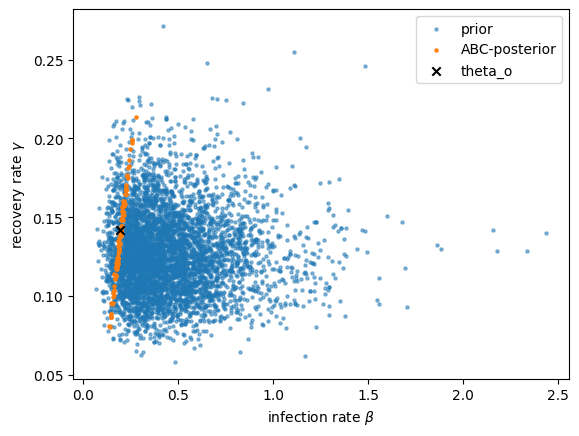

In [24]:
# Select number of samples for scatter plot.
num_prior_samples = 5000
plt.scatter(theta[:num_prior_samples, 0], theta[:num_prior_samples, 1], s=5, alpha=0.5, label="prior",)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], s=5, label="ABC-posterior")
plt.scatter(*true_theta[0], marker="x", color="k", label="theta_o")
plt.xlabel(r"infection rate $\beta$")
plt.ylabel(r"recovery rate $\gamma$")
plt.legend();

# Summary

## Simulation-based inference (SBI)

- Use Bayesian inference to identify parameters of simulation-based models
- Likelihood is not accessible $\to$ use data simulated from the model instead


## Part 1: "Classical SBI" aka Approximate Bayesian Computation (ABC)

<img src="_static/images/ABC_concept_figure.png" alt="Snow" style="width:100%;">

### Advantage

- Conceptually simple: fast to implement

### Disadvantages

- Curse of dimensionality: what if $\theta$ or $x$ is high-dimensional?


## Part 2: Machine learning-powered simulation-based inference

Use _conditional density estimation_ to learn a parametric approximation to the
posterior distribution: **neural density estimation**.

<img src="_static/images/sbi_concept_figure.png" alt="Snow" style="width:100%;">

Papamakarios et al. 2016; Cranmer et al. 2020, Figure from Boelts (2023)


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h2>Thank you for the attention!</h2>
</div>
